In [1]:
from fastai.vision.all import *

In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [3]:
path = Path('/home/user/images')

In [4]:
path.ls()

(#1000) [Path('/home/user/images/Bathygobius krefftii'),Path('/home/user/images/Oncorhynchus gorbuscha'),Path('/home/user/images/Chromis margaritifer'),Path('/home/user/images/Istigobius hoesei'),Path('/home/user/images/Abudefduf sordidus'),Path('/home/user/images/Acanthurus leucopareius'),Path('/home/user/images/Sphoeroides spengleri'),Path('/home/user/images/Orthopristis chrysoptera'),Path('/home/user/images/Etheostoma zonale'),Path('/home/user/images/Morone mississippiensis')...]

In [5]:
df_path = Path('/home/user/')

In [6]:
df = pd.read_csv(df_path/'csv/species1000-stratified.csv')

In [7]:
df

,Order,Family,Subfamily,Genus,Specie,fname,is_valid
0,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gibbosus,Lepomis gibbosus/1879321.jpg,False
1,Perciformes,Centrarchidae,NaN,Pomoxis,Pomoxis nigromaculatus,Pomoxis nigromaculatus/61056925.jpg,False
2,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis miniatus,Lepomis miniatus/36578909.jpg,False
3,Cypriniformes,Cyprinidae,Leuciscinae,Scardinius,Scardinius erythrophthalmus,Scardinius erythrophthalmus/77068790.jpg,False
4,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus olivaceus,Acanthurus olivaceus/14646458.jpg,False
...,...,...,...,...,...,...,...
422172,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus coeruleus,Acanthurus coeruleus/33472582.jpg,True
422173,Perciformes,Gobiidae,Gobiinae,Amblyeleotris,Amblyeleotris steinitzi,Amblyeleotris steinitzi/3789141.jpg,True
422174,Perciformes,Percidae,Etheostomatinae,Etheostoma,Etheostoma caeruleum,Etheostoma caeruleum/40879890.jpg,True
422175,Perciformes,Kyphosidae,Microcanthinae,Tilodon,Tilodon sexfasciatus,Tilodon sexfasciatus/26825770.jpg,True


In [8]:
weights_df = pd.read_csv(df_path/'csv/species1000-weights.csv')
weights_family_df = pd.read_csv(df_path/'csv/species1000-weights-family.csv')
weights_genus_df = pd.read_csv(df_path/'csv/species1000-weights-genus.csv')
weights_order_df = pd.read_csv(df_path/'csv/species1000-weights-order.csv')

In [9]:
weights_df

,Specie,Count,Weight
0,Abramis brama,319,1.323439
1,Abudefduf abdominalis,221,1.910303
2,Abudefduf bengalensis,323,1.307050
3,Abudefduf saxatilis,1692,0.249514
4,Abudefduf septemfasciatus,149,2.833403
...,...,...,...
995,Zanclus cornutus,1966,0.214739
996,Zebrasoma desjardinii,166,2.543235
997,Zebrasoma flavescens,561,0.752544
998,Zebrasoma scopas,276,1.529627


# Non-branch

In [10]:
fishes = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=ColReader(4),
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df, bs=64)

In [11]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, TensorCategory(531)),(PILImage mode=RGB size=1024x738, TensorCategory(776)),(PILImage mode=RGB size=768x1024, TensorCategory(538)),(PILImage mode=RGB size=768x1024, TensorCategory(837)),(PILImage mode=RGB size=1024x786, TensorCategory(32)),(PILImage mode=RGB size=1024x683, TensorCategory(145)),(PILImage mode=RGB size=768x1024, TensorCategory(827)),(PILImage mode=RGB size=1024x697, TensorCategory(792)),(PILImage mode=RGB size=1024x768, TensorCategory(784)),(PILImage mode=RGB size=1024x768, TensorCategory(522))...],
 (#84436) [(PILImage mode=RGB size=576x1024, TensorCategory(826)),(PILImage mode=RGB size=512x320, TensorCategory(296)),(PILImage mode=RGB size=1024x768, TensorCategory(283)),(PILImage mode=RGB size=1024x683, TensorCategory(223)),(PILImage mode=RGB size=1024x683, TensorCategory(333)),(PILImage mode=RGB size=1024x768, TensorCategory(272)),(PILImage mode=RGB size=1024x576, TensorCategory(163)),(PILImage mode=RGB size=1024x768, Tenso

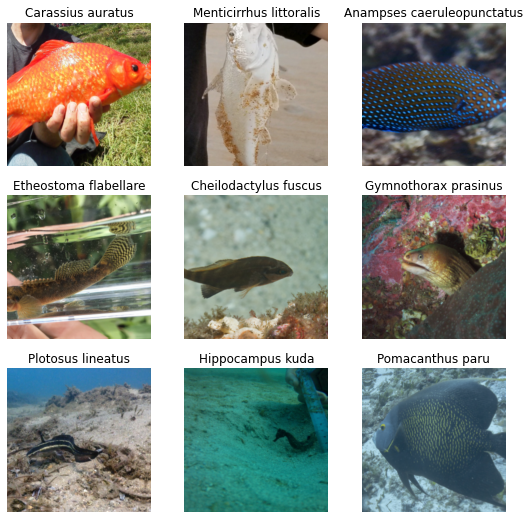

In [12]:
dls.show_batch(nrows=3, ncols=3)

In [13]:
class VGGCustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [14]:
def custom_splitter(model):
    return [params(model.encoder),
            params(model.head)]

In [15]:
model = vgg16_bn
body = create_body(model, cut=-2)
head = create_head(512*2,dls.c)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/user/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [16]:
model = VGGCustomModel(body, head)

In [17]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()

In [18]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [19]:
learn.summary()

VGGCustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 336 x 336  1,792      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 336 x 336  128        True      
________________________________________________________________
ReLU                 64 x 64 x 336 x 336  0          False     
________________________________________________________________
Conv2d               64 x 64 x 336 x 336  36,928     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 336 x 336  128        True      
________________________________________________________________
ReLU                 64 x 64 x 336 x 336  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 168 x 168  0          False     
_____________________________________________

In [20]:
learn.fit(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.659776,2.923297,0.395068,38:54


In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=1.3182567499825382e-06)

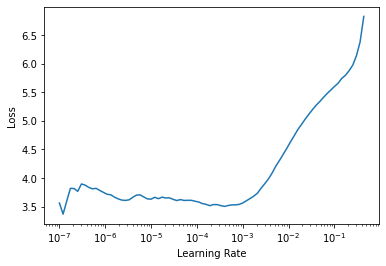

In [22]:
learn.lr_find()

In [23]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-nobranch-fepochs1-uepochs5')

epoch,train_loss,valid_loss,accuracy,time
0,3.102528,2.468492,0.481394,46:16
1,2.912167,2.326311,0.502025,46:14
2,2.857798,2.225966,0.518937,46:17
3,2.836672,2.149881,0.533434,46:08
4,2.655583,2.085060,0.542399,45:59


Path('models/species1000-vgg16-nobranch-fepochs1-uepochs5.pth')

In [24]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-nobranch-fepochs1-uepochs10')

epoch,train_loss,valid_loss,accuracy,time
0,2.666815,2.036729,0.551992,46:09
1,2.718378,1.987994,0.561692,46:11
2,2.605856,1.954902,0.565742,46:13
3,2.511580,1.913323,0.574838,46:16
4,2.621795,1.867491,0.580298,46:08


Path('models/species1000-vgg16-nobranch-fepochs1-uepochs10.pth')

In [25]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-nobranch-fepochs1-uepochs15')

epoch,train_loss,valid_loss,accuracy,time
0,2.371947,1.843256,0.583803,46:15
1,2.369555,1.825760,0.589168,46:13
2,2.349010,1.796251,0.594652,46:16
3,2.408113,1.762036,0.599247,46:15
4,2.293036,1.745851,0.603226,46:14


Path('models/species1000-vgg16-nobranch-fepochs1-uepochs15.pth')

In [26]:
learn.export('species1000-vgg16-nobranch-fepochs1-uepochs15')

# 1-Branch-CNN

In [12]:
model = vgg16_bn
body = create_body(model, cut=-2)
body

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/user/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
head = create_head(512*2,dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1000, bias=False)
)

In [14]:
_body = body[0]
block1 = _body[:7]
block2 = _body[7:14]
block3 = _body[14:24]
block4 = _body[24:34]
block5 = _body[34:]

In [15]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse1_label = o['Family']
    return [coarse1_label, fine_label]

In [16]:
class VGGCustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        encoder = encoder[0]
        self.block1 = encoder[:7]
        self.block2 = encoder[7:14]
        self.block3 = encoder[14:24]
        self.branch1 = create_head(256*2, len(set(df['Family'])))
        self.block4 = encoder[24:34]
        self.block5 = encoder[34:]
        self.head = head
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        coarse1_label = self.branch1(x)
        x = self.block4(x)
        x = self.block5(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse1_label': coarse1_label
               }

In [17]:
model = VGGCustomModel(body, head)

In [18]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [19]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [20]:
def custom_splitter(model):
    return [params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.block5),
            params(model.head)]

In [21]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [22]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse1_label': TensorCategory(41)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse1_label': TensorCategory(109)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse1_label': TensorCategory(108)}),(PILImage mode=RGB size=1024x697, {'fine_label': TensorCategory(792), 'coarse1_label': TensorCategory(100)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(784), 'coarse1_label': TensorCategory(9)}),(PILImage mode=R

In [23]:
dls.vocab, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...])

In [24]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()

In [25]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse1_label'], targ['coarse1_label'])

In [26]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [27]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [28]:
learn.summary()

VGGCustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 336 x 336  1,792      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 336 x 336  128        True      
________________________________________________________________
ReLU                 64 x 64 x 336 x 336  0          False     
________________________________________________________________
Conv2d               64 x 64 x 336 x 336  36,928     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 336 x 336  128        True      
________________________________________________________________
ReLU                 64 x 64 x 336 x 336  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 168 x 168  0          False     
_____________________________________________

In [29]:
learn.fit(1, 3e-3)
learn.save('species1000-vgg16-branch1-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,8.952939,7.935008,0.372341,36:49


Path('models/species1000-vgg16-branch1-fepochs1-uepochs0.pth')

In [30]:
learn.unfreeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.9054607491852948e-06)

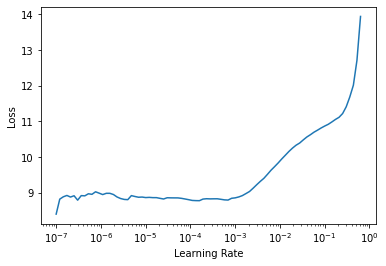

In [31]:
learn.lr_find()

In [32]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-branch1-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,7.846222,6.998443,0.520963,43:46
1,7.522415,6.695027,0.559110,43:48
2,7.257742,6.503053,0.590459,43:50
3,7.030668,6.361246,0.602314,43:49
4,6.884535,6.243983,0.614773,43:49


Path('models/species1000-vgg16-branch1-fepochs1-uepochs5.pth')

In [33]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-branch1-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,6.834618,6.154070,0.628831,43:50
1,6.764784,6.074899,0.639336,43:51
2,6.686830,6.010394,0.646928,43:50
3,6.524913,5.953050,0.653904,43:52
4,6.459052,5.903843,0.656935,43:51


Path('models/species1000-vgg16-branch1-fepochs1-uepochs10.pth')

In [34]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-branch1-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,6.362367,5.848131,0.666173,43:51
1,6.466002,5.808759,0.668613,43:52
2,6.309824,5.772195,0.674416,43:52
3,6.213349,5.755435,0.676868,43:53
4,6.160876,5.711276,0.685430,43:55


Path('models/species1000-vgg16-branch1-fepochs1-uepochs15.pth')

In [35]:
learn.export('species1000-vgg16-branch1-fepochs1-uepochs15')

# 2-Branch-CNN

In [11]:
model = vgg16_bn
body = create_body(model, cut=-2)
head = create_head(512*2,dls.c)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/user/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [12]:
_body = body[0]
block1 = _body[:7]
block2 = _body[7:14]
block3 = _body[14:24]
block4 = _body[24:34]
block5 = _body[34:]

In [13]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse2_label = o['Family']
    coarse1_label = o['Order']
    return [coarse1_label, coarse2_label, fine_label]

In [14]:
class VGGCustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        encoder = encoder[0]
        self.block1 = encoder[:7]
        self.block2 = encoder[7:14]
        self.branch1 = create_head(128*2, len(set(df['Order'])))
        self.block3 = encoder[14:24]
        self.branch2 = create_head(256*2, len(set(df['Family'])))
        self.block4 = encoder[24:34]
        self.block5 = encoder[34:]
        self.head = head
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        coarse1_label = self.branch1(x)
        x = self.block3(x)
        coarse2_label = self.branch2(x)
        x = self.block4(x)
        x = self.block5(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse2_label': coarse2_label,
                'coarse1_label': coarse1_label
               }

In [15]:
model = VGGCustomModel(body, head)

In [16]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)
        self.vocab_coarse2 = None if vocab_coarse2 is None else CategoryMap(vocab_coarse2, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[2] for d in dsets]
        coarse2_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse2 is None and dsets is not None: self.vocab_coarse2 = CategoryMap(coarse2_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[2]]),
                                  'coarse2_label': TensorCategory(self.vocab_coarse2.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [17]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [18]:
def custom_splitter(model):
    return [params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.block5),
            params(model.head)]

In [19]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [20]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse2_label': TensorCategory(41), 'coarse1_label': TensorCategory(10)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse2_label': TensorCategory(0), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse2_label': TensorCategory(109), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse2_label': TensorCategory(108), 'coarse1_la

In [21]:
dls.vocab, dls.vocab_coarse2, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...],
 (#29) ['Acipenseriformes','Amiiformes','Anguilliformes','Atheriniformes','Aulopiformes','Batrachoidiformes','Beloniformes','Beryciformes','Characiformes','Clupeiformes'...])

In [22]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_order = tensor([float(weights_order_df[weights_order_df['Order']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse2]).cuda()

In [23]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_order)(out['coarse1_label'], targ['coarse1_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse2_label'], targ['coarse2_label'])

In [24]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [25]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [26]:
learn.summary()

VGGCustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 336 x 336  1,792      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 336 x 336  128        True      
________________________________________________________________
ReLU                 64 x 64 x 336 x 336  0          False     
________________________________________________________________
Conv2d               64 x 64 x 336 x 336  36,928     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 336 x 336  128        True      
________________________________________________________________
ReLU                 64 x 64 x 336 x 336  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 168 x 168  0          False     
_____________________________________________

In [27]:
learn.fit(1, 3e-3)
learn.save('species1000-vgg16-branch2-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,12.558345,11.402443,0.358011,37:09


Path('models/species1000-vgg16-branch2-fepochs1-uepochs0.pth')

In [28]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.9054607491852948e-06)

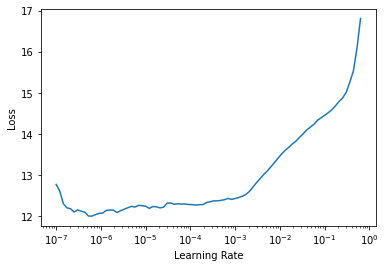

In [29]:
learn.lr_find()

In [30]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-branch2-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,11.597372,10.457061,0.503956,44:16
1,11.110071,10.093249,0.554242,44:18
2,10.916301,9.859887,0.578367,44:17
3,10.691870,9.695148,0.598963,44:22
4,10.514062,9.566904,0.608354,44:18


Path('models/species1000-vgg16-branch2-fepochs1-uepochs5.pth')

In [31]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-branch2-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,10.271805,9.466129,0.624757,44:20
1,10.163678,9.358991,0.631532,44:19
2,10.108641,9.287456,0.639076,44:19
3,9.980215,9.236080,0.644535,44:21
4,9.906014,9.167691,0.654744,44:21


Path('models/species1000-vgg16-branch2-fepochs1-uepochs10.pth')

In [32]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-vgg16-branch2-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,9.750738,9.101320,0.656876,44:20
1,9.722359,9.066955,0.661175,44:21
2,9.770606,9.018344,0.667594,44:19
3,9.714917,8.982452,0.671680,44:21
4,9.628518,8.932809,0.675079,44:22


Path('models/species1000-vgg16-branch2-fepochs1-uepochs15.pth')

In [33]:
learn.export('species1000-vgg16-branch2-fepochs1-uepochs15')